In [1]:
from notebook_helper import *
from helpers import la, space, viz
from helpers.la_mapping import lower_tier_sandwich, lower_tier_layer, gdf_chart
notebook_setup()
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

# CO2 emissions cluster analysis

The goal of this analysis is to use [BEIS measures of the CO2 emissions](https://data.gov.uk/dataset/723c243d-2f1a-4d27-8b61-cdb93e5b10ff/uk-local-authority-and-regional-carbon-dioxide-emissions-national-statistics-2005-to-2019) under a local authorities control (the subset dataset) to:

1. Determine for each council which other councils are most similar. 
2. Group councils into clusters that explain broadly the problem of their emissions and why they are similar. 

This first attempt uses as dimensions the five grand totals for Industry, Commerical, Domestic, Public Sector, Transport.  

The data is conformed to the current 2021 local authorities, and reduced to just principal authorities.

Although the data has some higher level authorities, their totals are then recreated using the sum of their constituent parts. 

All authorities are then divided by the 2020 population to get a per capita figure. Go back and forth on if this is a good idea, but essentally lets us isolate the question of 'big' authorities for a seperate comparison system.

One thing the per capita approach causes problems with is the City of London, which shows up as such an outlier I exclude it from clustering approaches. 

In [2]:
data_year = 2019

df = pd.read_excel(Path("data", "2005-19_UK_local_and_regional_CO2_emissions.xlsx"),
                   sheet_name="Subset dataset", header=1)
df = df.loc[df["Year"] == data_year].loc[~df["Code"].isna()]

used_cols = ["Industry Total", "Commercial Total", "Domestic Total", "Public Sector Total", "Transport Total"]

df = df[["Code"] + used_cols]

# transform to principal modern councils
df = (df
      .la.create_code_column(from_type="gss", source_col="Code")
      .drop(columns=["Code"])
      .la.to_current()
      .la.just_principals())

higher_df = df.la.to_higher(aggfunc="sum")

df = pd.concat([df, higher_df])

original_df = df.copy()

df = df.la.get_council_info(["region", "pop_2020"])

#convert to per capita emissions
for c in used_cols:
      df[c] = (df[c]/df["pop_2020"])*100

df = df.drop(columns=["pop_2020"])
df["region"] = df["region"].fillna("Unknown")
df = df.set_index("local-authority-code")
df.head()

,Industry Total,Commercial Total,Domestic Total,Public Sector Total,Transport Total,region
local-authority-code,,,,,,
ABC,0.202964,0.018739,0.176830,0.004395,0.201933,Northern Ireland
ABD,0.118983,0.037371,0.184972,0.008194,0.240239,Scotland
ABE,0.066342,0.067903,0.149283,0.042369,0.142631,Scotland
ADU,0.029168,0.023936,0.126134,0.006697,0.145878,South East
AGB,0.126624,0.052611,0.188899,0.018173,0.213968,Scotland


## Comparsions to physical distance

Comparing the distance between all councils (where the input variables are normalised so there is a mean of 0 and a SD of 1) to the physical distance between councils there is very little agreement on the closest councils. 

The table below shows the agreement between councils in a top k comparison (where k = 1 is the nearest council, k = 10 is the nearest 10 councils). There is on average only a 11% agreement in the top 25 councils. 

In [3]:
relevant_cols = ["Industry Total", "Commercial Total", "Domestic Total", "Public Sector Total", "Transport Total"]
pol_distance = df.space.self_distance("local-authority-code", relevant_cols, normalize=True)

pol_distance.to_csv(Path("data","outputs","council_clusters_v1_distance.csv"), index=False)

real_distance = pd.read_csv(Path("data", "outputs", "geographic_distance.csv" ))

jd = space.join_distance({"pollution_distance": pol_distance,
                         "real_distance": real_distance})
jd.joint_space.agreement()


,top_k,agreement
0,1,0.01
1,2,0.02
2,3,0.03
3,5,0.04
4,10,0.06
5,25,0.11


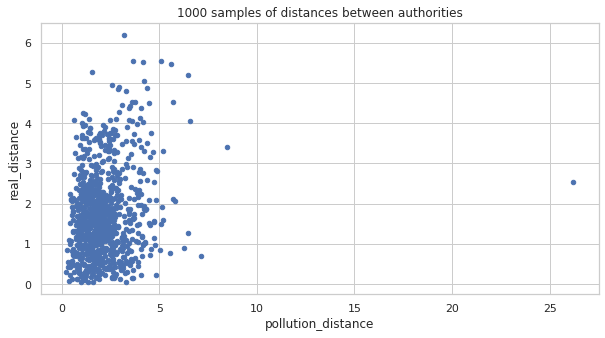

In [4]:
plot = jd.joint_space.plot(sample=1000, title="1000 samples of distances between authorities")

There is Similar dispersal of distances, but no clear pattern (although not many far away, and *also* similar pollution).
Remember all the coordinates were normalised before use, so this is *distance* between spaces on normalised dimensions. 
This also shows that some councils can have quite a high pollution distance, but be very *close*. This validates the general approach of exploring alternatives to distance. 


## Clustering

Using k means clustering, this section tries to group local authorities into a set of clusters of different profiles of emissions. 

Because this has been adjusted per capita, the City of London gets very high numbers, and so fits badly into other clusters. It is dropped from these purposes (or can be said to be a cluster of 1). 

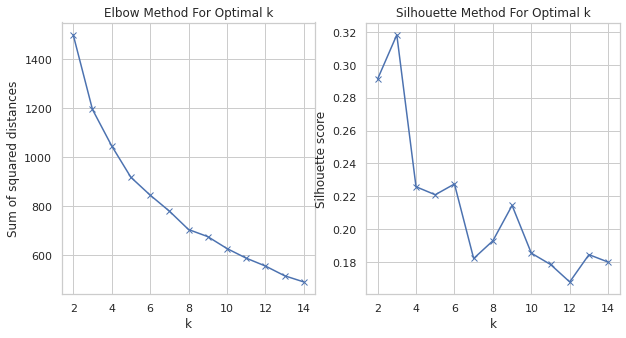

In [5]:
# drop london because it ends up on its own anyway and distorts the scores
cdf = df.drop(index=["LND"]).reset_index()
cluster = space.Cluster(cdf, "local-authority-code", cols = relevant_cols, label_cols=["region"], normalize=True)
cluster.find_k(2,15)

# Chosing 6 clusters 

The relatively slow decent reflects that there is not clear clusters in the data, cloosing 6 as a high point in the silhouette score.

In [6]:
# Choosing 6 clusters, but in general this isn't that much different. Data is not clearly clustered.
cluster.set_k(6)

nice_name_lookup = la.get_la_df().set_index("local-authority-code")["official-name"].to_dict()
stats = cluster.stats(label_lookup=nice_name_lookup)
stats

,count,%,random members
labels,,,
1,122,30.1,"[East Hampshire District Council, Peterborough..."
2,165,40.7,"[Torfaen County Borough Council, Falkirk Counc..."
3,43,10.6,"[Leicestershire County Council, Hambleton Dist..."
4,7,1.7,"[The Moray Council, City of Westminster, Clack..."
5,2,0.5,"[Gloucestershire County Council, Warwickshire ..."
6,66,16.3,"[West Lancashire Borough Council, Neath Port T..."


Broadly, this splits the data into three 'Mainstream' categories, and three 'Outlier' categories. Where the majority are in the mainstream categories, and the outliers are generally better defined (but much smaller) clustesr. 

Using the label and raincloud tool, descriptions were created of how these labels relate to the variables being grouped. 

In [14]:
# examine variables individually
cluster.raincloud_tool()

interactive(children=(Dropdown(description='variable', options=('Industry Total', 'Commercial Total', 'Domesti…

In [8]:
cluster.label_tool()

interactive(children=(Dropdown(description='cluster', options=(1, 2, 3, 4, 5, 6), value=1), Dropdown(descripti…

In [9]:
cluster.assign_name(n=1, name="Mainstream B", desc="Above average industry/transport/domestic")
cluster.assign_name(n=2, name="Mainstream A", desc="Below average commercial/industry/transport/domestic")
cluster.assign_name(n=3, name="Outlier A", desc="Above average transport, industry, domestic")
cluster.assign_name(n=4, name="Outlier B", desc="Above average commercial/public sector")
cluster.assign_name(n=5, name="Outlier C", desc="Very above average domestic and transport")
cluster.assign_name(n=6, name="Mainstream C", desc="Above average commercial/public sector, below average transport/domestic")
cluster.stats(label_lookup=nice_name_lookup)

,count,%,random members
labels,,,
1: Mainstream B,122,30.1,"[Torridge District Council, Forest of Dean Dis..."
2: Mainstream A,165,40.7,"[Bury Metropolitan Borough Council, Bournemout..."
3: Outlier A,43,10.6,"[Leicestershire County Council, Dumfries and G..."
4: Outlier B,7,1.7,"[Cambridge City Council, Clackmannanshire Coun..."
5: Outlier C,2,0.5,"[Gloucestershire County Council, Warwickshire ..."
6: Mainstream C,66,16.3,"[Gloucester City Council, Cheltenham Borough C..."


## Area and population

Breaking down the labels by area and population, While Mainstream A is the largest group by population, Mainstream B is more rural and contains the largest amount of the land. Similarly, Outlier A has a very low density.

In [10]:
df = cluster.df_with_labels()
df = df.la.get_council_info(["area", "pop_2020"])
df = df.la.just_principals()
pt = df.pivot_table(["area", "pop_2020"], index=["label"], aggfunc="sum")
pt["area"] = (pt["area"] / pt["area"].sum()).round(3)
pt["pop_2020"] = (pt["pop_2020"] / pt["pop_2020"].sum()).round(3)
pt = pt.reset_index()
pt.style.format({
    'area': '{:.1%}'.format,
    'pop_2020': '{:.1%}'.format
})


,label,area,pop_2020
0,Mainstream A,13.6%,44.5%
1,Mainstream B,44.1%,25.5%
2,Mainstream C,3.9%,21.5%
3,Outlier A,37.3%,6.8%
4,Outlier B,1.0%,1.7%


In [11]:
#export with pre per-capita numbers

ldf = cluster.df_with_labels().set_index("local-authority-code")
ldf = ldf[["label", "label_desc"]]
ndf = original_df.copy().set_index("local-authority-code")
ndf = ndf.join(ldf, how="left").reset_index()
ndf = ndf.la.get_council_info(["official-name", "local-authority-type-name"])
ndf.to_csv(Path("data", "outputs", "council_clusters_v1.csv"), index=False)

## Is there any benefit to increasing the number of variables?

The `pollution.ks` notebook explores using *all* the sub-variables. Broadly this produces a set of coherent clusters, but still has the same gradual decline and puts most councils in a single mainstream category. The approach in this notebook is preferable for the moment. 

## How does this work in practice?

In terms of how this information is presented, there are several considerations:

* All variables have now been transformed several times, so the raw 'distance' means very little. 
* Per capita emissions is very abstract anyway. 

So in the example below, there are no units and everything is presented in relative terms:

* Per capita emissions are grouped into deciles (Where 10 is high).
* Distance is reframed as a percentage match score, where a perfect match is 0 distance, and a 0% match is the distance of the furthest but 10 councils. This is because per capita makes London so far away that it distorts all other distances. So going 10 from the end is stopping this outlier distortion.

The below shows an example for Leeds (an interactive version can be seen using the `lookup_demo.ipynb`).

In [12]:

dmd = lambda x: display(md(x))

# prepare decile guide
cdf = pd.read_csv(Path("data", "outputs", "council_clusters_v1.csv"))
cdf = cdf.la.get_council_info(["pop_2020"]).set_index(
    "local-authority-code")

for c in cdf.columns:
    if "Total" in c:
        name = " ".join(c.split(" ")[:-1]) +" Emissions Decile"
        per_capita = cdf[c] / cdf["pop_2020"]
        cdf[name] = pd.qcut(per_capita, 10,
                                    labels=range(1, 11), duplicates="drop")

ddf = pd.read_csv(Path("data", "outputs", "council_clusters_v1_distance.csv")) #"council_clusters_v1_distance.csv"


def standardise_distance(df):
    df = df.copy()
    # use tenth from last because the last point might be an extreme outlier (in this case london)
    tenth_from_last_score = df["distance"].sort_values().tail(10).iloc[0]
    df["match"] = 1 - (df["distance"] / tenth_from_last_score)
    df["match"] = df["match"].round(3) * 100
    df = df.sort_values("match", ascending=False)
    df = df.drop(columns="local-authority-code_A")
    return df

ddf = ddf.groupby("local-authority-code_A").apply(standardise_distance)

def display_council(council_slug):
    wanted_columns = ["official-name", "match",
                    "local-authority-type-name", "label"]

    matches = ddf.loc[council_slug].sort_values("match", ascending=False).head(10)
    matches = matches.set_index("local-authority-code_B").join(cdf).reset_index()
    matches = matches[wanted_columns]

    details = cdf.loc[council_slug].to_dict()

    dmd(f'## {details["official-name"]}')
    dmd(f'**Type**: {details["local-authority-type-name"]}')
    dmd(f'**Cluster**: {details["label"]} - {details["label_desc"]}')

    deciles = cdf.loc[cdf.index == council_slug][[x for x in cdf.columns if "Decile" in x]]
    deciles = deciles.transpose().rename(columns={council_slug:"Decile"})
    dmd("### Decile profiles")
    dmd("Decile 10 is the highest emissions, decile 1 is the lowest.")

    display(deciles)

    dmd("### Nearest neighbours")
    display(matches)

display_council("LDS")

## Leeds City Council

**Type**: Metropolitan district

**Cluster**: Mainstream C - Above average commercial/public sector, below average transport/domestic

### Decile profiles

Decile 10 is the highest emissions, decile 1 is the lowest.

,Decile
Industry Emissions Decile,4
Commercial Emissions Decile,7
Domestic Emissions Decile,4
Public Sector Emissions Decile,9
Transport Emissions Decile,4


### Nearest neighbours

,official-name,match,local-authority-type-name,label
0,Derby City Council,92.7,Unitary authority,Mainstream A
1,Lancaster City Council,92.2,Non-metropolitan district,Mainstream A
2,Dover District Council,92.0,Non-metropolitan district,Mainstream A
3,Renfrewshire Council,91.5,Scottish unitary authority,Mainstream C
4,Bath and North East Somerset Council,91.2,Unitary authority,Mainstream A
5,City of York Council,91.1,Unitary authority,Mainstream A
6,City of Wolverhampton Council,91.1,Metropolitan district,Mainstream A
7,Liverpool City Region,90.9,Combined authority,Mainstream C
8,North Lanarkshire Council,90.0,Scottish unitary authority,Mainstream A
9,West Yorkshire Combined Authority,89.2,Combined authority,Mainstream A


# Map of clusters

And finally, a map for lower-tier authorities of their respective clusters.



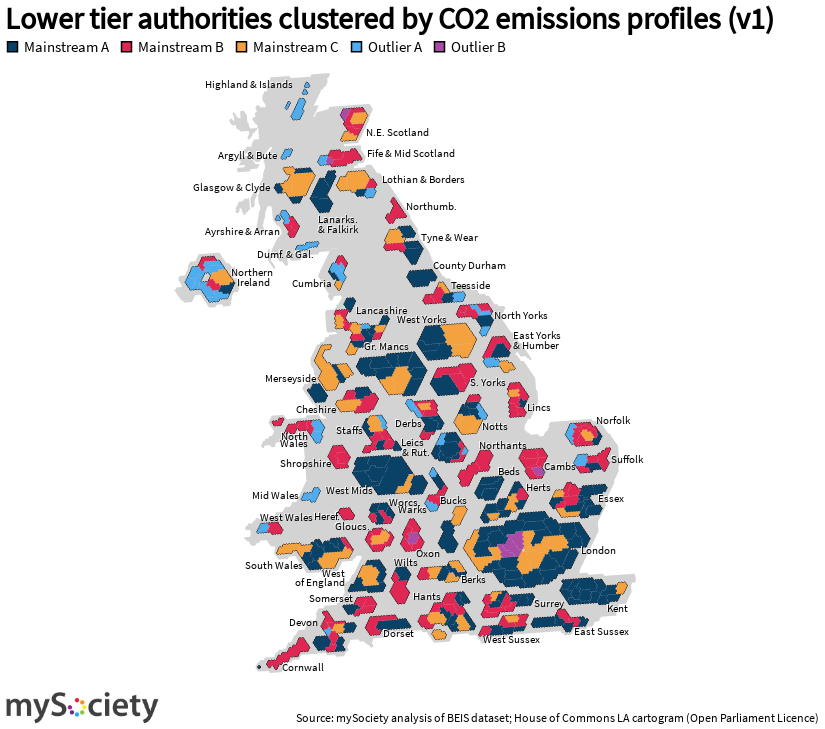

In [16]:

df = ndf[["local-authority-code", "label"]]
# remove london
df = df.loc[df["local-authority-code"] != "LND"]
df = df.loc[df["label"] != "Outlier C"]
df["label"] = df["label"].fillna("Other")
subtitle=""
la_layer = lower_tier_layer().merge(df, how="left")

labels = list(df["label"].unique())
labels.sort(key=lambda x: x if x != "Other" else "Z")
color_scale = altair_theme.color_scale(domain=labels)

#create chart layer
chart = gdf_chart(la_layer).mark_geoshape(
    stroke='black',
    strokeWidth=0
).encode(color=alt.Color("properties.label:O",
                         scale=color_scale,
                         legend=alt.Legend(title=subtitle, orient="top",titleFontSize=18, labelFontSize=15, titleLimit= 400))
).properties(
    title= "Lower tier authorities clustered by CO2 emissions profiles (v1)"
)

# put between layers
chart = lower_tier_sandwich(chart)

#final properties
chart = chart.properties(width=800,height=600)
caption = "Source: mySociety analysis of BEIS dataset; House of Commons LA cartogram (Open Parliament Licence)"
chart.display(logo=True, scale_factor=1, caption=caption)
save_chart(chart, Path("data", "outputs", "cluster_map.png"), scale_factor=2, logo=True, caption=caption )